In [1]:
### venv: py37
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import neuro_morpho_toolbox as nmt
# import neuro_morpho_toolbox.plot as nmtp
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import MaxNLocator
import pickle
# from sklearn.cluster import KMeans
# from sklearn.cluster import DBSCAN
# import scipy.cluster.hierarchy as sch

import pymrmr
import matplotlib.ticker as mticker
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
# from scipy import spatial
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
# from  matplotlib import patches
# import scienceplots
import random

min_max_scaler = MinMaxScaler()
plt.style.use(['science', 'no-latex'])

def reassign_region_id():
    region_used=nmt.bs.selected_regions
    origin_ccf = np.array(nmt.annotation.array[:, :, :], dtype=np.uint32)
    selected_annotaion = np.zeros_like(nmt.annotation.array, dtype=np.uint32)
    for region in region_used:
        #get its child region
        child_regions = nmt.bs.get_all_child_id(region)
        if len(child_regions) == 0:
            ix, iy, iz = np.where(origin_ccf == region)
            selected_annotaion[ix, iy, iz] = region
            continue
        for childregion in child_regions:
            ix, iy, iz = np.where(origin_ccf == childregion)
            selected_annotaion[ix, iy, iz] = region
    print('processing finished, reassign region id to its parent_id')
    return selected_annotaion

def get_region_swc(cswc,
                   annotation=nmt.annotation,
                   brain_structure=nmt.bs,
                   region_used=None):
    tp = cswc.copy()
    tp = pd.DataFrame(
        {
            "x": np.array(np.array(tp.x),dtype="int32"),
            "y": np.array(np.array(tp.y),dtype="int32"),
            "z": np.array(np.array(tp.z),dtype="int32")
        },
        index=tp.index)
    tp = tp[((tp.x >= 0) & (tp.x < annotation.size['x']) & (tp.y >= 0) &
             (tp.y < annotation.size['y']) & (tp.z >= 0) &
             (tp.z < annotation.size['z']))]

    # Add region id to the dataframe
    if region_used is None:
        region_used = nmt.bs.selected_regions
        dict_to_used = nmt.bs.dict_to_selected
    else:
        assert all([
            (i in brain_structure.level.index.tolist()) for i in region_used
        ]), "Given regions invalid. Please check 'region_used'."
        dict_to_used = {}
        for cur_region in region_used:
            child_ids = nmt.bs.get_all_child_id(cur_region)
            for i in child_ids:
                dict_to_used[i] = cur_region
    tp["region_id"] = np.array(annotation.array[tp.x, tp.y, tp.z], dtype=int)
    tp = tp[tp.region_id.isin(list(dict_to_used.keys()))]
    tp["region_id"] = np.array(tp["region_id"].map(dict_to_used), dtype=int)
    res = cswc.copy()
    res['region_id'] = 0
    res.loc[tp.index, 'region_id'] = tp['region_id']
    return res

def get_soma_region(infile):
    inswc=nmt.swc.neuron(infile).swc
    rootnum=inswc[inswc.parent<0].shape[0]
    if rootnum != 1:
        print('Soma error: ', infile.split('/')[-1],' ; size= ', rootnum)
        return 'error'
    soma=inswc[inswc.parent<0].copy()
    soma['x']=soma['x']/25
    soma['y']=soma['y']/25
    soma['z']=soma['z']/25
    somar=get_region_swc(cswc=soma,annotation=my_annotation)
    soma_rid=somar['region_id'].tolist()[0]
    if soma_rid >0:
        return nmt.bs.id_to_name(soma_rid)
    return 'error'

ccf_reassigned_f='../data/Fig4/ccf_reassigned.pickle'
if os.path.exists(ccf_reassigned_f):
    with open(ccf_reassigned_f,'rb') as f:
        my_annotation=pickle.load(f)
else:
    print('reassign start... will take a long time.')
    selected_annotaion=reassign_region_id()
    my_annotation=nmt.annotation
    my_annotation.array=selected_annotaion
    with open(ccf_reassigned_f,'wb') as f:
        pickle.dump(my_annotation,f)
TH=['AD','AM','AV','CL','CM','IAD','LD','LGd','LHA','LP','MD','MG','MM','PCN','PF','PIL','PO','POL','PR','PVT',
   'PoT','RE','RT','SGN','SMT','TH','VAL','VM','VPL','VPLpc','VPM','VPMpc']
CTX=['ACAd','ACAv','AId','AIp','AIv','AON','AON','AUDd','AUDpo','AUDv','BLA','BMA','CA1','CA3','CLA','COAp','HPF','DG',
    'ECT','ENTl','ENTm','EPd','FRP','GU','IG','ILA','MOB','MOp','MOs','ORBl','ORBm','ORBvl','PIR','PL','POST','PRoS',
    'RSPagl','RSPd','RSPv','SSs','SUB','TEa','TR','VISC','VISa','VISal','VISam','VISl','VISli','VISp','VISpm',
    'VISpor','VISrl','SSp','SSp-bfd','SSp-ll','SSp-m','SSp-n','SSp-tr','SSp-ul','SSp-un','AUDp','PAA','ProS']
CNU=['ACB','BST','CEA','CP','FS','GPe','GPi','LSr','LSv','OT','PAL','PAR','PRE','SI','NDB','AAA']
HY=['AHN','DMH','HY','PH','PSTN','PVH','PVi','PeF','SBPV','TU','VMH','ZI']
CB=['CENT','COPY','CUL','DEC','FL','FN','FOTU','NOD','PFL','AN','PRM','PYR','SIM']
MB=['DR','IC','MB','MRN','MV','MY','PAG','RN','SNc']
HB=['IRN','LRN','MDRNd','MDRNv','P','PARN','PB','PG','PGRNl','PRNc','PRNr','PSV','SPIV','SPVC','SPVO','SUV','TRN',
   'V','VCO']
btype=['CNU','TH','CTX']
bcolors=['#75bbfd','#029386','#ff796c']
cnu_stypes=['CP','OT']
th_stypes=['VPM','VPL','LGd','LP','VPLpc','MG', 'RT']
ctx_stypes=['MOp', 'MOs','SSp','SSs','AId', 'RSPv', 'CLA']
ana_regions=['CP','OT','VPM','VPL','LGd','LP','VPLpc','MG', 'RT',
        'SSp-bfd','SSp-ul','SSp-ll','SSp-m','SSp-n', 'SSp-un',
        'MOp', 'MOs','SSs', 'AId', 'RSPv', 'CLA']
ana_stypes=['CP','OT','VPM','VPL','LGd','LP','VPLpc','MG', 'RT',
        'SSp','MOp', 'MOs','SSs', 'AId', 'RSPv', 'CLA']
ssp_regions=['SSp-bfd','SSp-ul','SSp-ll','SSp-m','SSp-n', 'SSp-un']
btype=['TH','CNU','CTX']
bcolors=['#029386','#75bbfd','#ff796c']

/Users/jiangshengdian/opt/anaconda3/envs/py37/lib/python3.7/site-packages/neuro_morpho_toolbox-0.1-py3.7.egg/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.62
Loading CCF brain structure data...
Loading time: 0.00
Loading flat_map ...
Loading time: 18.79


In [2]:
# swc processing lib
def get_soma(infile,flip=True):
    inswc=nmt.swc.neuron(infile).swc
    rootnum=inswc[inswc.parent<0].shape[0]
    if rootnum != 1:
        print('Soma error: ', infile.split('/')[-1],' ; size= ', rootnum)
        return 0
    soma=inswc[inswc.parent<0].copy()
    soma=soma.iloc[0]
    soma=soma[['x','y','z']]
    sz=soma['z']/25
    if flip and sz > nmt.annotation.size['z']/2:
        # print('flip')
        sz= nmt.annotation.size['z'] - sz
        soma['z'] = sz *25
    return soma
def readswc(file,headrow=2):
    header=['n','type','x','y','z','radius','parent']
    swc=pd.read_csv(file,sep=' ',header=None,skiprows=3)
    swc.columns=header
    swc.set_index(['n'],drop=True,inplace=True)
    return swc
def saveswc(swc,tofile,scale=1,retype=None,xshift=0,flip=False):
    header=['##n','type','x','y','z','radius','parent']
    if retype is not None:
        swc['type']=retype
    if scale != 1 and scale >0:
        swc['x']/=scale
        swc['y']/=scale
        swc['z']/=scale
    if xshift:
        swc['x']+=xshift
    soma=swc[swc.parent<0].copy()
    soma=soma.iloc[0]
    sz=soma['z']
    if flip and sz > nmt.annotation.size['z']/2:
        swc['z']= nmt.annotation.size['z'] - swc['z']
    swc.reset_index(inplace=True)
    swc.to_csv(tofile,sep=' ',index=0,header=header)
def get_degree(tswc):
    tswc['degree'] = tswc['parent'].isin(tswc.index).astype('int')
    # print(tswc['degree'])
    n_child = tswc.parent.value_counts()
    n_child = n_child[n_child.index.isin(tswc.index)]
    tswc.loc[n_child.index, 'degree'] = tswc.loc[n_child.index, 'degree'] + n_child
    return tswc
def get_rid(swc):
    '''
    Find root node.
    '''
    rnode=swc[((swc['parent']<0) & (swc['type']<=1))]
    if rnode.shape[0]<1:
        return -1
    return rnode.index[0]
def get_keypoint(swc, rid=None):
    if rid is None:
        rid = get_rid(swc)
    #print(swc.shape)
    swc=get_degree(swc)
    idlist = swc[((swc.degree!=2) | (swc.index==rid))].index.tolist()
    return idlist
def swc2branches(swc):
    '''
    reture branch list of a swc
    '''
    keyids=get_keypoint(swc)
    branches=[]
    for key in keyids:
        if swc.loc[key,'parent']<0 | swc.loc[key,'type']<=1:
            continue
        branch=[]
        branch.append(key)
        pkey=swc.loc[key,'parent']
        while True:
            branch.append(pkey)
            if pkey in keyids:
                break
            key=pkey
            pkey=swc.loc[key,'parent']
        branches.append(branch)
    return branches

In [3]:
# get lm features
fdir='../data/Fig4/lmfeas'
fea_names=None
allfeas=pd.DataFrame()
for root,dirs,files in os.walk(fdir):
    for mfile in files:
        if os.path.splitext(mfile)[1] != '.csv':
            continue
        file_in=os.path.join(root,mfile)
        tdf=pd.read_csv(file_in)
        vlist=tdf['value'].to_list()
        if fea_names is None:
            fea_names=tdf['feature'].to_list()
            # allfeas.columns=fea_names
        allfeas[mfile.split('.swc')[0]]=vlist
allfeas.index=fea_names
allfeas=allfeas.T
allfeas.index.name='name'
allfeas.to_csv('lm_statistics_full.csv')
# get cell type
r1741_type='../data/Fig4/1741_Celltype.csv'
r1741df=pd.read_csv(r1741_type,index_col=['name'])
raw_feas_file='../data/Fig4/ana_lm_statistics_full.csv'
# swcdir='../data/Fig4/reg_ccf'
swcdir='../data/Fig4/reg_ccf_s20'
fromFile=True
recompute_size=0
if fromFile and os.path.exists(raw_feas_file):
    all_features_raw=pd.read_csv(raw_feas_file,index_col=['name'])
else:
    for swc in allfeas.index:
        fbname=swc
        bid=fbname.split('_')[0]
        if bid == 'pre':
            bid=fbname.split('_')[1]
        if bid == '15257':
            fbname='210254_'+fbname.split('5257_')[1]
        if fbname in r1741df.index:
            soma_region=r1741df.loc[fbname,'Soma_region']
        else:
            swcf=os.path.join(swcdir,swc+'.swc')
            soma_region=get_soma_region(swcf)
            
        allfeas.loc[swc,'soma_region']=soma_region
    # all_features_raw=allfeas[(allfeas.soma_region != 'error') & (allfeas.soma_region != 'fiber tracts')].copy()
    allfeas.to_csv(raw_feas_file)


/Users/jiangshengdian/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [4]:
# cos_dist
'''
single cells × morphological features的矩阵 （倘若n*200) 
对这n个样本计算similarity （我用的cosine similarity）产生一个n*n的相似性矩阵（归一化到0-1） 
然后在产生一个n*n的欧氏距离矩阵 再用高斯核函数把它转换为相似性矩阵（也是0-1） 然后二者相乘
欧氏距离矩阵除以max距离 放缩到0-1 然后高斯核函数用的变换是np.exp(-dist_mat**2)
'''
pd.options.display.float_format = '{:,.2f}'.format

def cosine_similarity(indf,feas=None,norm=True):
    # normalize to 0-1
    indata=indf.copy()
    outdf=pd.DataFrame(dtype='float64')
    if feas is not None:
        indata=indf[feas].copy()
    for i1,c1 in enumerate(indata.index):
        for i2,c2 in enumerate(indata.index):
            if i1>i2:
                continue
            if i1==i2:
                outdf.loc[c1,c2]=1
                continue
            vec1 = indata.loc[c1,:]
            vec2 = indata.loc[c2,:]
            cos_sim = np.float64(vec1.dot(vec2) /( np.linalg.norm(vec1) * np.linalg.norm(vec2)))
            outdf.loc[c1,c2]=cos_sim
            outdf.loc[c2,c1]=outdf.loc[c1,c2]
    if norm:
        mmscaler=MinMaxScaler(feature_range=(0,1))
        all_fea_s=mmscaler.fit_transform(outdf.values)
        standard_feas=pd.DataFrame(all_fea_s,columns=outdf.columns,index=outdf.index)
        return standard_feas
    else:
        return outdf
def spatial_dist(inlist,soma_dir=None):
    outdf=pd.DataFrame(dtype='float64')
    somalist=[]
    for cell in inlist:
        s_path=os.path.join(soma_dir,cell+'.swc')
        if os.path.join(s_path):
            soma=get_soma(s_path)
            somalist.append(soma)
        else:
            return 0
    for i1,c1 in enumerate(inlist):
        for i2,c2 in enumerate(inlist):
            if i1>i2:
                continue
            if i1==i2:
                outdf.loc[c1,c2]=0
                continue
            soma1=somalist[i1]
            soma2=somalist[i2]
            # if soma1 and soma2:
            outdf.loc[c1,c2]=np.sqrt((soma1['x']-soma2['x'])*(soma1['x']-soma2['x'])+
                                    (soma1['y']-soma2['y'])*(soma1['y']-soma2['y'])+
                                    (soma1['z']-soma2['z'])*(soma1['z']-soma2['z']))
            outdf.loc[c2,c1]=outdf.loc[c1,c2]
    max_dist=outdf.max().max()
    outdf/=max_dist
    return np.exp(-outdf**2)
def cell_similarity(indf,feas=None,norm=True):
    indata=indf.copy()
    outdf=pd.DataFrame(dtype='float64')
    if feas is not None:
        indata=indf[feas].copy()
    #1 cosine simailarity
    cosine_sim=cosine_similarity(indata)
    #2 spatial dist
    spatial_sim=spatial_dist(indata.index,soma_dir='../data/reg_ccf_s20')
    return cosine_sim*spatial_sim

def euc_similarity(indf,feas=None,norm=True):
    indata=indf.copy()
    outdf=pd.DataFrame(dtype='float64')
    if feas is not None:
        indata=indf[feas].copy()
    for i1,c1 in enumerate(indata.index):
        for i2,c2 in enumerate(indata.index):
            if i1>i2:
                continue
            if i1==i2:
                outdf.loc[c1,c2]=1
                continue
            vec1 = indata.loc[c1,:].to_numpy()
            vec2 = indata.loc[c2,:].to_numpy()
            temp=vec1-vec2
            edist = np.sqrt(np.dot(temp.T, temp))
            outdf.loc[c1,c2]=(edist)
            outdf.loc[c2,c1]=outdf.loc[c1,c2]
    if norm:
        max_dist=outdf.max().max()
        outdf=outdf/max_dist
        return np.exp(-outdf**2)
    else:
        return outdf

## clustering based on morphological features and spatial distance

In [9]:
# for the computation of dist wighted features
cbase=['black','#db1561','#2a7b7b','#392b78','#785498','#3fa540','#F6BBC6']
allfeas_raw=pd.read_csv('ana_lm_statistics_full.csv',index_col=['name'])
all_flag=True
if all_flag:
    ana_feas_data=allfeas_raw.copy()
    allfeas_df=ana_feas_data.drop(['soma_region'],axis=1).copy()
else:
    allfeas_raw.loc[:,'brain_region']= 'Other'
    allfeas_raw.loc[allfeas_raw['soma_region'].isin(CNU),'brain_region']= 'CNU'
    allfeas_raw.loc[allfeas_raw['soma_region'].isin(CTX),'brain_region']= 'CTX'
    allfeas_raw.loc[allfeas_raw['soma_region'].isin(TH),'brain_region']= 'TH'
    ana_feas_data=allfeas_raw[allfeas_raw.brain_region!='Other'].copy()
    allfeas_df=ana_feas_data.drop(['soma_region','brain_region'],axis=1).copy()
tof_path='../data/Fig4/ana_similarity.csv'
tof_morpho_path='../data/Fig4/ana_morpho_similarity.csv'
tof_spatial_path='../data/Fig4/ana_spatial_similarity.csv'
if os.path.exists(tof_path):
    all_sim=pd.read_csv(tof_path,index_col=None)
    all_sim.index=all_sim.keys()
else:
    if os.path.exists(tof_morpho_path):
        cosine_sim_all=pd.read_csv(tof_morpho_path,index_col=None)
        cosine_sim_all.index=cosine_sim_all.keys()
    else:
        allfeas_s=StandardScaler().fit_transform(allfeas_df.values)
        allfeas_df_s=pd.DataFrame(allfeas_s,columns=allfeas_df.keys(),index=allfeas_df.index)
        cosine_sim_all=cosine_similarity(allfeas_df_s)
        cosine_sim_all.to_csv(tof_morpho_path,index=False)
    #2 spatial dist
    if os.path.exists(tof_spatial_path):
        spatial_sim_all=pd.read_csv(tof_spatial_path,index_col=None)
        spatial_sim_all.index=spatial_sim_all.keys()
    else:
        spatial_sim_all=spatial_dist(allfeas_df.index.to_list(),soma_dir='../data/reg_ccf_s20')
        spatial_sim_all.to_csv(tof_spatial_path,index=False)
    all_sim=cosine_sim_all*spatial_sim_all
    all_sim.to_csv(tof_path,index=False)
for cell in all_sim.index:
    if all_sim.loc[cell,cell] !=1:
        # print(cell,all_sim.loc[cell,cell])
        all_sim.loc[cell,cell]=1.0
all_sim_tmp=all_sim.replace(np.nan,0)
# allfeas_df['brain_region']=allfeas_raw['brain_region']
allfeas_df['soma_region']=allfeas_raw['soma_region']
n_clusters=4
clustering = SpectralClustering(n_clusters=n_clusters,affinity='precomputed',random_state=0).fit(all_sim_tmp)
allfeas_df['cluster']=clustering.labels_

/Users/jiangshengdian/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning:

Array is not symmetric, and will be converted to symmetric by average with its transpose.



In [12]:
# re-org cluster label
allfeas_df.loc[allfeas_df['cluster']==1,'cluster']=-1
allfeas_df.loc[allfeas_df['cluster']==2,'cluster']=-2
allfeas_df.loc[allfeas_df['cluster']==3,'cluster']=-3
allfeas_df.loc[allfeas_df['cluster']==0,'cluster']=3
allfeas_df.loc[allfeas_df['cluster']==-1,'cluster']=2
allfeas_df.loc[allfeas_df['cluster']==-2,'cluster']=0
allfeas_df.loc[allfeas_df['cluster']==-3,'cluster']=1

### Fig4a

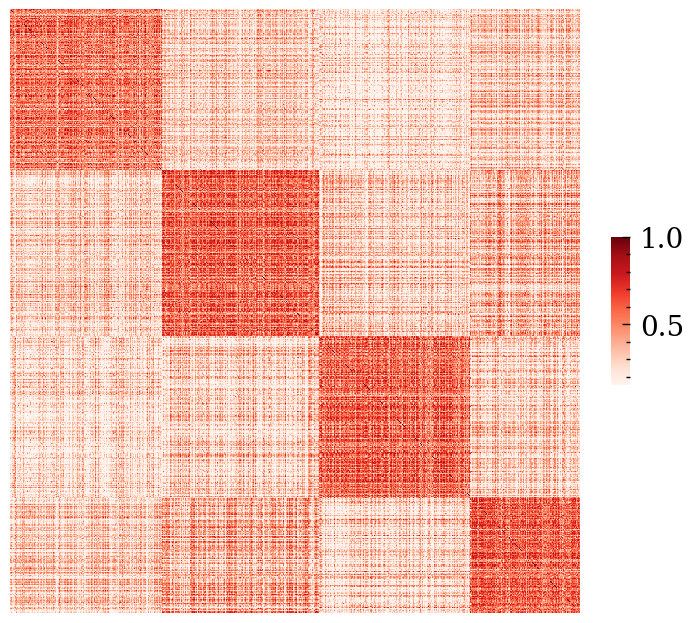

In [13]:
# print("#clusters=",str(resultall.max()-resultall.min()+1))

cluster_sorted_list=allfeas_df[allfeas_df.cluster==0].index.to_list()
for c in np.arange(1,n_clusters):
    cluster_sorted_list+=allfeas_df[allfeas_df.cluster==c].index.to_list()
showdata=all_sim_tmp[cluster_sorted_list].copy()
showdata=showdata.T[cluster_sorted_list].copy()
fig=plt.figure(figsize=(4,4),dpi=200)
fs=5
plt.subplot(111)
ax=sns.heatmap(showdata.values,
                cmap='Reds',
                xticklabels=False,
                yticklabels=False,
                vmin=0.15,
                cbar_kws={
                'orientation':'vertical',
                'fraction':0.03,
                'aspect':8,
                })
plt.show()
fig.savefig('../figs/all_cell_clustermap.png',dpi=300)

In [14]:
allfeas_df

,stems,branches,overall_width,overall_height,overall_depth,overall_volume,total_length,br_length_mean,br_length_std,br_length_min,...,tilt_local_mean,tilt_local_std,tilt_local_min,tilt_local_max,tilt_remote_mean,tilt_remote_std,tilt_remote_min,tilt_remote_max,soma_region,cluster
name,,,,,,,,,,,,,,,,,,,,,
18454_01067,10.00,610.00,"3,379.60","1,656.76","2,764.05","15,476,400,000.00","52,424.50",85.94,143.75,1.02,...,112.76,30.63,1.92,173.89,118.28,27.41,12.33,164.19,VPM,3
191801_4228_x15043_y11097,5.00,295.00,953.91,"1,401.26",533.67,"713,343,000.00","16,153.00",54.76,61.28,0.30,...,106.50,39.03,1.48,167.62,110.72,36.15,5.59,172.13,OT,2
18457_00127,6.00,520.00,"3,013.65","3,885.40","4,059.88","47,538,100,000.00","63,427.90",121.98,254.46,0.40,...,109.20,31.45,4.79,166.25,104.28,35.15,11.22,170.62,MG,3
17302_00015,7.00,229.00,"1,589.49","1,547.01","1,210.67","2,976,990,000.00","26,880.30",117.38,123.97,1.30,...,115.05,28.90,41.60,173.13,94.55,34.90,10.61,164.44,CP,2
18465_00005,8.00,620.00,"4,265.99","2,381.37","1,798.78","18,273,600,000.00","28,720.10",46.32,105.70,0.53,...,104.20,32.51,2.47,168.51,102.03,33.30,4.29,168.80,CP,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18458_00086,5.00,487.00,"2,271.47","3,197.16","1,798.67","13,062,400,000.00","51,520.60",105.79,153.64,0.47,...,118.58,28.89,25.29,164.13,118.55,28.02,14.84,165.89,LGd,1
18455_5517_x15391_y12702,6.00,726.00,"3,686.52","2,654.78","2,807.85","27,480,100,000.00","82,965.80",114.28,162.77,0.58,...,115.83,28.67,4.28,169.18,115.90,31.37,1.92,166.66,PO,3
18454_00141,9.00,637.00,"2,896.52","1,261.16","3,100.25","11,325,100,000.00","52,465.20",82.36,106.81,0.76,...,114.10,32.30,14.16,175.23,121.31,26.95,18.30,170.27,VPLpc,3


In [24]:
allfeas_df.keys()

Index(['stems', 'branches', 'overall_width', 'overall_height', 'overall_depth',
       'overall_volume', 'total_length', 'br_length_mean', 'br_length_std',
       'br_length_min', 'br_length_max', 'br_order_mean', 'br_order_std',
       'br_order_min', 'br_order_max', 'br_tortuosity_mean',
       'br_tortuosity_std', 'br_tortuosity_min', 'br_tortuosity_max',
       'bif_EucDist2soma_mean', 'bif_EucDist2soma_std', 'bif_EucDist2soma_min',
       'bif_EucDist2soma_max', 'bif_PathDist2soma_mean',
       'bif_PathDist2soma_std', 'bif_PathDist2soma_min',
       'bif_PathDist2soma_max', 'asymmetry_mean', 'asymmetry_std',
       'asymmetry_min', 'asymmetry_max', 'ampl_local_mean', 'ampl_local_std',
       'ampl_local_min', 'ampl_local_max', 'ampl_remote_mean',
       'ampl_remote_std', 'ampl_remote_min', 'ampl_remote_max',
       'tilt_local_mean', 'tilt_local_std', 'tilt_local_min', 'tilt_local_max',
       'tilt_remote_mean', 'tilt_remote_std', 'tilt_remote_min',
       'tilt_remote_max', 's

In [19]:
inva_feas=[ 'asymmetry_min','asymmetry_max',  
            'br_length_min', 'br_order_min',
            'br_tortuosity_min','br_tortuosity_max',
            'bif_PathDist2soma_min','bif_EucDist2soma_min',
            'ampl_local_min','ampl_remote_min','tilt_local_min','tilt_remote_min']
allfeas_df.loc[:,'brain_region']= 'Others'
allfeas_df.loc[allfeas_df['soma_region'].isin(CNU),'brain_region']= 'CNU'
allfeas_df.loc[allfeas_df['soma_region'].isin(CTX),'brain_region']= 'CTX'
allfeas_df.loc[allfeas_df['soma_region'].isin(TH),'brain_region']= 'TH'
allfeas_df.to_csv('../data/Fig4/ana_features_dataframe.csv')
gfdf_raw=allfeas_df.copy()
gfdf_raw.drop(inva_feas,axis=1,inplace=True)
gfdf_raw.dropna(inplace=True)
gfdf=gfdf_raw.copy()
# fea_names=gfdf.drop(['cluster','soma_region'],axis=1).keys().to_list()
# all_fea_s=StandardScaler().fit_transform(gfdf.drop(['cluster','soma_region'],axis=1).values)
fea_names=gfdf.drop(['cluster','soma_region','brain_region'],axis=1).keys().to_list()
all_fea_s=StandardScaler().fit_transform(gfdf.drop(['cluster','soma_region','brain_region'],axis=1).values)
standard_feas=pd.DataFrame(all_fea_s,columns=fea_names,index=gfdf.index)

In [18]:
### count other
### # of neurons innervate from non-dominant brain areas for clusters C1, C2, C3, and C4
for c in np.arange(n_clusters):
    cdata=allfeas_df[allfeas_df.cluster==c].copy()
    print(c,cdata.shape[0])
    cdata.drop(['cluster','soma_region'],axis=1,inplace=True)
    dominate_group='CNU'
    dominate_group_neurons=0
    for bt in btype:
        dgroup=cdata.groupby('brain_region').get_group(bt).shape[0]
        if dominate_group_neurons < dgroup:
            dominate_group = bt
            dominate_group_neurons=dgroup
    print(c,dominate_group,dominate_group_neurons)
    print('other=',round(1-dominate_group_neurons/cdata.shape[0],2))

0 502
0 CTX 474
other= 0.06
1 515
1 TH 384
other= 0.25
2 499
2 CNU 343
other= 0.31
3 360
3 TH 319
other= 0.11


### Fig4b

In [21]:
gfdf_with_soma=gfdf.drop(['soma_region','brain_region'],axis=1).copy()
showdata_for_clusters=[]
for anac in np.arange(n_clusters):
    gfdf_with_soma_cluster=gfdf_with_soma[gfdf_with_soma.cluster==anac].copy()
    gfdf_with_soma_cluster.drop(['cluster'],axis=1,inplace=True)
    typical_stype_fea=gfdf_with_soma_cluster.median()
    min_fea_dist=1000000000000000000
    typical_cell=gfdf_with_soma_cluster.index[0]
    for cell in gfdf_with_soma_cluster.index:
        this_cell_fea=gfdf_with_soma_cluster.loc[cell,:].copy()
        fea_dist=(this_cell_fea-typical_stype_fea).abs().sum()
        # print(fea_dist)
        if fea_dist < min_fea_dist:
            typical_cell=cell
        # break
    # showdata_for_cluster=[typical_cell]
    showdata_for_cluster=[]
    clist=random.choices(gfdf_with_soma_cluster.index.to_list(),k=5)
    showdata_for_cluster+=clist
    showdata_for_clusters.append(showdata_for_cluster)

In [22]:
# for vis, need to flip swc
todir='../data/Fig4/morpho_showdata'
tdir='../data/Fig4/reg_ccf_s20_25um'
# import shutil
if not os.path.exists(todir):
    os.mkdir(todir)
for ci,cells in enumerate(showdata_for_clusters):
    cdir=os.path.join(todir,str(ci))
    if not os.path.exists(cdir):
        os.mkdir(cdir)
    for si,cell in enumerate(cells):
        topath=os.path.join(cdir,str(si+1)+'_'+cell+'.swc')
        frompath=os.path.join(tdir,cell+'.swc')
        rawswc=nmt.swc.neuron(frompath).swc
        saveswc(swc=rawswc,tofile=topath,scale=1,xshift=0,flip=True)
        # shutil.copy(frompath,topath)

### Fig4c

soma statistics of various clusters

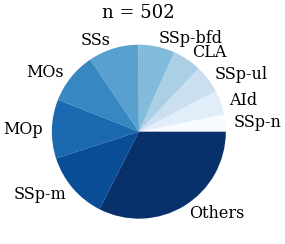

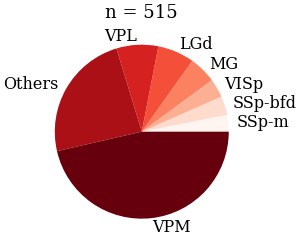

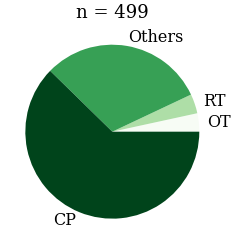

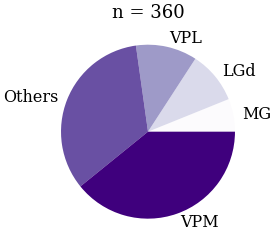

In [20]:
# cluster vs soma_region
cmaps=['Blues','Reds','Greens','Purples']
ccc=['blue','red','green','purple']
for anac in np.arange(n_clusters):
    # anac=2
    allfeas_cluster_df = allfeas_df[allfeas_df.cluster==anac].groupby('soma_region').size()
    cell_num=allfeas_cluster_df.sort_values().T
    showpie=pd.DataFrame()
    other_num=0
    for stype in allfeas_cluster_df.index:
        if cell_num[stype]<16:
            other_num+=cell_num[stype]
        else:
            showpie.loc[stype,'soma_region']=cell_num[stype]
    showpie.loc['Others','soma_region']=other_num
    # Make the plot with pandas
    showpie.sort_values(by='soma_region',inplace=True)
    axes=showpie.plot(kind='pie',y='soma_region', figsize=(4,4),fontsize=16,legend=False,colormap=cmaps[anac])
    plt.title('n = '+str(cell_num.sum()),fontsize=18)
    plt.ylabel("")
    # plt.legend(False)
    plt.show()
    # sfig=np.mat(sfig)
    # axe = axes.ravel()
    showpie_fig=axes.get_figure()
    showpie_fig.savefig('../figs/Cluster_stype_distribution_'+str(anac)+'.png',dpi=200)

In [ ]:
# cluster vs brain_region
cmaps=['Blues','Reds','Greens','Purples']
ccc=['blue','red','green','purple']
allfeas_df.loc[:,'brain_region']= 'Others'
allfeas_df.loc[allfeas_df['soma_region'].isin(CNU),'brain_region']= 'CNU'
allfeas_df.loc[allfeas_df['soma_region'].isin(CTX),'brain_region']= 'CTX'
allfeas_df.loc[allfeas_df['soma_region'].isin(TH),'brain_region']= 'TH'
for anac in np.arange(n_clusters):
    # anac=2
    allfeas_cluster_df = allfeas_df[allfeas_df.cluster==anac].groupby('brain_region').size()
    cell_num=allfeas_cluster_df.sort_values().T
    showpie=pd.DataFrame()
    other_num=0
    for stype in allfeas_cluster_df.index:
        if cell_num[stype]<15:
            other_num+=cell_num[stype]
        else:
            showpie.loc[stype,'brain_region']=cell_num[stype]
    if other_num>0:
        showpie.loc['Others','brain_region']=other_num
    # Make the plot with pandas
    showpie.sort_values(by='brain_region',inplace=True)
    axes=showpie.plot(kind='pie',y='brain_region', 
                      figsize=(4,4),fontsize=16,
                      labels=[str(100*round(showpie.loc[r,'brain_region']/showpie['brain_region'].sum(),2))+'%' for r in showpie.index],
                      legend=False,colormap=cmaps[anac])
    # plt.title('n = '+str(cell_num.sum()),fontsize=18)
    plt.ylabel("")
    # plt.legend(False)
    plt.show()
    # sfig=np.mat(sfig)
    # axe = axes.ravel()
    showpie_fig=axes.get_figure()
    showpie_fig.savefig('../figs/Cluster_btype_distribution_'+str(anac)+'.png',dpi=200)
    # break

soma distribution

In [23]:
soma_dir='../data/Fig4/reg_ccf_s20'
# soma coord to marker
##x,y,z,radius,shape,name,comment, color_r,color_g,color_b
def hex_to_rgb(hex):
  return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

# scolors=['95d0fc','06c2ac','ff796c','9a0eea']
sco=['16499D','E71F19','36AE37','7D4195']
for c1 in np.arange(n_clusters):
    for c2 in np.arange(n_clusters):
        if c1 >= c2:
            continue
        soma_markers=pd.DataFrame()
        for c in ([c1,c2]):
            cdata=gfdf[gfdf.cluster==c].copy()
            sc=sco[c]
            rgb=hex_to_rgb(sc)
            for cell in cdata.index:
                rpath=os.path.join(soma_dir,cell+'.swc')
                if cdata.loc[cell,'soma_region'] == 'error':
                    continue
                if os.path.join(rpath):
                    soma=get_soma(rpath)
                    soma_markers.loc[cell,'##x']=int(soma['x']/25+20)
                    soma_markers.loc[cell,'y']=int(soma['y']/25)
                    soma_markers.loc[cell,'z']=int(soma['z']/25)
                    soma_markers.loc[cell,'radius']=0
                    soma_markers.loc[cell,'shape']=cdata.loc[cell,'cluster']+1
                    soma_markers.loc[cell,'name']='C'+str(cdata.loc[cell,'cluster']+1)
                    soma_markers.loc[cell,'comment']='soma'
                    soma_markers.loc[cell,'color_r']=int(rgb[0])
                    soma_markers.loc[cell,'color_g']=int(rgb[1])
                    soma_markers.loc[cell,'color_b']=int(rgb[2])
        soma_markers.to_csv('../data/Fig4/soma_marker_in_vtk/soma_'+str(c1)+'_vs_'+str(c2)+'.marker',index=False,float_format='%.0f')
# soma_markers.index.name='##'
# soma_markers.to_csv('../data/allsoma.marker',index=False,float_format='%.0f')

In [24]:
# for the collection of soma coord
gfdf_with_soma=gfdf.copy()
for cell in gfdf_with_soma.index:
    rpath=os.path.join(soma_dir,cell+'.swc')
    # if gfdf_with_soma.loc[cell,'soma_region'] == 'error':
    #     continue
    if not os.path.exists(rpath):
        continue
    soma=get_soma(rpath,flip=True)
    gfdf_with_soma.loc[cell,'x']=int(soma['x'])
    gfdf_with_soma.loc[cell,'y']=int(soma['y'])
    gfdf_with_soma.loc[cell,'z']=int(soma['z'])
for c1 in np.arange(n_clusters):
    for c2 in np.arange(n_clusters):
        if c1 >= c2:
            continue
        two_clusters_data=gfdf_with_soma[gfdf_with_soma.cluster.isin([c1,c2])]
        X=two_clusters_data[['x','y','z']].values
        labels=two_clusters_data['cluster'].values
        scils = silhouette_score(X, labels)
        print(str(c1)+'_'+str(c2)+':', round(scils,3))

0_1: 0.209
0_2: 0.071
0_3: 0.245
1_2: 0.223
1_3: 0.023
2_3: 0.224


Discriminating features in primary subspaces

In [25]:
def mrmr_fea_all_type(indata,picked_fea=3,stype_list=None):
    if stype_list is None:
        stype_list=indata['cluster'].value_counts().keys().to_list()
    ana_data=indata.copy()
    for i,f1 in enumerate(stype_list):
        ana_data.loc[ana_data.cluster==f1,'cluster']=(1+i)
    new_fea_list=['cluster']
    for fea in fea_names:
        new_fea_list.append(fea)
    ana_data=ana_data[new_fea_list]
    mrmrout=pymrmr.mRMR(ana_data,'MID',picked_fea)
    return mrmrout
def mrmr_fea_pairtype(indata,picked_fea=3,stype_list=None):
    if stype_list is None:
        stype_list=indata['cluster'].value_counts().keys().to_list()
    sfeas=['mRMR'+str(x) for x in np.arange(1,picked_fea+1)]
    outkeys=['s1','s2']+sfeas
    outdf=pd.DataFrame()
    for i,f1 in enumerate(stype_list):
        for j,f2 in enumerate(stype_list):
            if i >= j:
                continue
            data_2stypes=indata[indata.cluster.isin([f1,f2])].copy()
            data_2stypes.loc[data_2stypes.cluster==f1,'cluster']=1
            data_2stypes.loc[data_2stypes.cluster==f2,'cluster']=2
            new_fea_list=['cluster']
            for fea in fea_names:
                new_fea_list.append(fea)
            data_2stypes=data_2stypes[new_fea_list]
            mrmrout=pymrmr.mRMR(data_2stypes,'MID',picked_fea)
            # print(len(mrmrout))
            out_tmp=[f1,f2]+mrmrout
            out_tmpdf=pd.DataFrame(out_tmp)
            outdf=pd.concat([outdf,out_tmpdf],axis=1,ignore_index=True)   
    outdata=outdf.T.copy()
    outdata.columns=outkeys
    return outdata
standard_feas['cluster']=gfdf['cluster']
standard_feas.dropna(inplace=True)
dataraw=standard_feas.copy()
# allbfeas=mrmr_fea_all_type(indata=dataraw,picked_fea=3)
allbfeas=mrmr_fea_pairtype(indata=dataraw,picked_fea=3)

In [26]:
allbfeas

,s1,s2,mRMR1,mRMR2,mRMR3
0,1,0,bif_EucDist2soma_max,tilt_remote_std,total_length
1,1,2,tilt_remote_mean,asymmetry_mean,ampl_remote_std
2,1,3,br_order_max,tilt_remote_std,bif_EucDist2soma_mean
3,0,2,bif_EucDist2soma_max,ampl_remote_mean,overall_height
4,0,3,bif_EucDist2soma_max,br_order_std,br_length_mean
5,2,3,bif_PathDist2soma_mean,br_tortuosity_std,branches


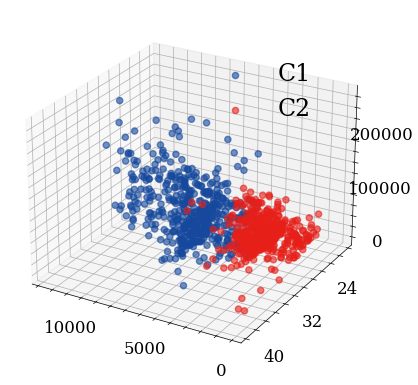

In [42]:
def d3d_types(indf,regions=['TH','CNU'],
                    colors=['blue','red'],
                    dims=['length','volume','contraction'],
                    labels=None,legend=True,
                    figpath=None,alpha=0.5,fs=12,
                    viewx=0,viewy=0):
    fig=plt.figure(figsize=(4,4),dpi=100)
    ax = fig.add_subplot(projection='3d')
    indf=indf[indf.cluster.isin(regions)].copy()
    for bi,br in enumerate(regions):
        sdata=indf[indf.cluster==br].copy()
        ax.scatter(sdata[dims[0]],sdata[dims[1]],sdata[dims[2]],c=colors[bi],
                    # label=br,
                    label='C'+str(br+1),
                    alpha=alpha,
                    # marker=MarkerStyle(marker='o',fillstyle='none'),
                    s=20*np.ones(sdata.shape[0]))
    if legend:
        plt.legend(loc='upper left',bbox_to_anchor=(0.5,0.9),title='',fontsize=fs+2)
    
    if labels is None:
        ax.set_xlabel(dims[0],fontsize=fs)
        ax.set_ylabel(dims[1],fontsize=fs)
        ax.set_zlabel(dims[2],fontsize=fs)
    else:
        ax.set_xlabel(labels[0],fontsize=fs)
        ax.set_ylabel(labels[1],fontsize=fs)
        ax.set_zlabel(labels[2],fontsize=fs)
    # First remove fill
    ax.tick_params(axis='x',labelsize=12)
    ax.xaxis.set_major_locator(MaxNLocator(3))
    ax.tick_params(axis='y',labelsize=12)
    ax.yaxis.set_major_locator(MaxNLocator(3))
    ax.tick_params(axis='z',labelsize=12)
    ax.zaxis.set_major_locator(MaxNLocator(3))
    # ax.set_xticks([])
    # ax.xaxis.set_ticklabels(fontsize=fs-1)
    # ax.xaxis.pane.fill = False
    # ax.yaxis.pane.fill = False
    # ax.zaxis.pane.fill = False

    # # Now set color to white (or whatever is"invisible")
    # ax.xaxis.pane.set_edgecolor('w')
    # ax.yaxis.pane.set_edgecolor('w')
    # ax.zaxis.pane.set_edgecolor('w')
    # # ax.grid(linestyle=':')
    # # ax.set_title('Distribution at optimal feature subspace')
    if viewx !=0 or viewy !=0:
        ax.view_init(viewx,viewy)
        # ax.xaxis._axinfo['juggled'] = (0,0,0)
        # ax.yaxis._axinfo['juggled'] = (1,1,1)
        # ax.zaxis._axinfo['juggled'] = (1,2,2)
    plt.tight_layout()
    plt.show()
    if figpath is not None:
        fig.savefig(figpath,dpi=300)
    return fig,ax
for cmp_pair in allbfeas.index:
    s1=allbfeas.loc[cmp_pair,'s1']
    s2=allbfeas.loc[cmp_pair,'s2']
    cmp_feas=allbfeas.loc[cmp_pair,['mRMR1','mRMR2','mRMR3']]
scolors=['#16499D','#E71F19','#36AE37','#7D4195']
for cmp_pair in allbfeas.index:
    if cmp_pair != 0:
        continue
    s1=allbfeas.loc[cmp_pair,'s1']
    s2=allbfeas.loc[cmp_pair,'s2']
    if s2<s1:
        s2=allbfeas.loc[cmp_pair,'s1']
        s1=allbfeas.loc[cmp_pair,'s2']
    cmp_feas=allbfeas.loc[cmp_pair,['mRMR1','mRMR2','mRMR3']].to_list()
    cpcolors=[scolors[s1],scolors[s2]]
    d3d_types(indf=gfdf,regions=[s1,s2],
                colors=cpcolors,
                dims=cmp_feas,
                labels=['','',''],
                # labels=cmp_feas,
                # legend=False,
                figpath='../figs/cluster_'+str(s1)+'_vs_'+str(s2)+'.png',
                alpha=0.6,fs=15,
                viewx=25,viewy=120
                )
    # break

### Fig4D

In [28]:
def mrmr_feag_pick(indata,picked_fea=3,stype_list = None):
    if stype_list is None:
        stype_list=indata['cluster'].value_counts().keys().to_list()
    outdf=pd.DataFrame()
    for i,f1 in enumerate(stype_list):
        for j,f2 in enumerate(stype_list):
            if i >= j:
                if i ==j:
                    outdf.loc[f1,f2]='-'
                continue
            data_2stypes=indata[indata.cluster.isin([f1,f2])].copy()
            data_2stypes.loc[data_2stypes.cluster==f1,'cluster']=1
            data_2stypes.loc[data_2stypes.cluster==f2,'cluster']=2
            new_fea_list=['cluster']
            for fea in fea_names:
                new_fea_list.append(fea)
            data_2stypes=data_2stypes[new_fea_list]
            mrmrout=pymrmr.mRMR(data_2stypes,'MID',picked_fea)
            feag_index=[fea_names.index(x) for x in mrmrout]
            feag_str=''
            for mfi,mf in enumerate(sorted(feag_index)):
                fea_append=(str(mf)+',')
                if mfi == len(mrmrout) -1:
                    fea_append = str(mf)
                feag_str+=fea_append
            outdf.loc[f1,f2]=feag_str
            outdf.loc[f2,f1]=feag_str
    return outdf
data_raw=standard_feas[standard_feas.cluster>=0].copy()
# data_raw=standard_feas[standard_feas.soma_region.isin(['MOp','MOs','SSs'])].copy()
# data_raw.drop(['name','brain_region'],axis=1,inplace=True)
# data_raw.loc[data_raw.soma_region.isin(['SSp-bfd','SSp-ul','SSp-ll','SSp-m','SSp-n']),'soma_region']='SSp'
# subfeas=mrmr_feag_pick(indata=data_raw,picked_fea=3,stype_list=fregions)
# data_raw.loc[data_raw.soma_region.isin(TH),'soma_region']='TH_Stypes'
subfeas=mrmr_feag_pick(indata=data_raw,picked_fea=3)
# subfeas.to_numpy().reshape(1,-1).tolist()[0]
# subfeas
# most selected feature for each stype
frank_2sts=pd.DataFrame(index=subfeas.index,columns=fea_names)
for s in subfeas.index:
    for fea in fea_names:
        frank_2sts.loc[s,fea]=0
for s1 in subfeas.index:
    for s2 in subfeas.keys():
        selected_str=subfeas.loc[s1,s2]
        selected_repo=[x for x in selected_str.split(',')]
        for fi,fea in enumerate(fea_names):
            frank_2sts.loc[s1,fea]+=selected_repo.count(str(fi))
# frank_2sts
frank_2sts_h=frank_2sts.copy()
thre_times=1
for fea in frank_2sts.keys():
    if frank_2sts[fea].max() < thre_times:
        frank_2sts_h.drop([fea],axis=1,inplace=True)
frank=[frank_2sts_h[x].sum() for x in frank_2sts_h.keys()]
frank.sort()
feas=frank_2sts_h.keys().to_list()
feas_sort=[]
for x in frank:
    for f in (frank_2sts_h.keys().to_list()):
        if (frank_2sts_h[f].sum() == x) and feas.count(f):
            feas_sort.append(f)
            fi=feas.index(f)
            del feas[fi]
            break
frank_pair=frank_2sts_h[feas_sort].astype(np.int32).T
frank_pair

,1,0,2,3
branches,0,0,1,1
overall_height,0,1,1,0
total_length,1,1,0,0
br_length_mean,0,1,0,1
br_order_std,0,1,0,1
br_order_max,1,0,0,1
br_tortuosity_std,0,0,1,1
bif_EucDist2soma_mean,1,0,0,1
bif_PathDist2soma_mean,0,0,1,1
asymmetry_mean,1,0,1,0


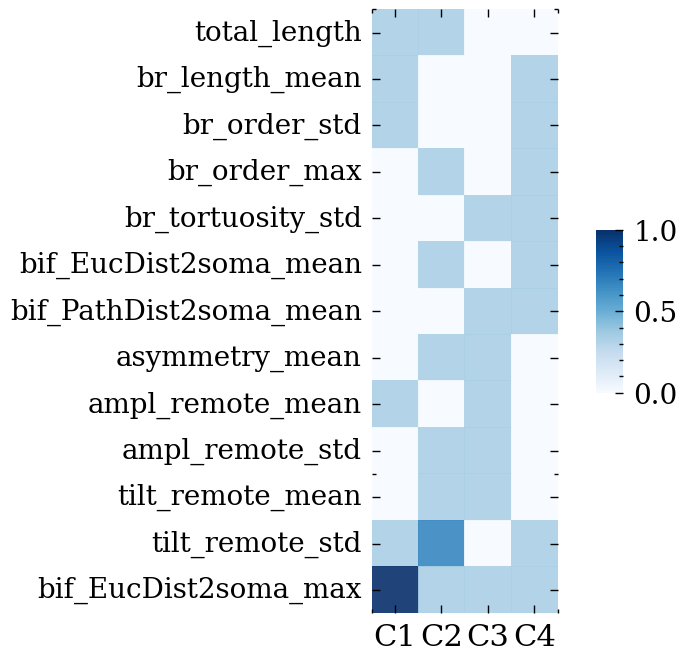

In [29]:
newslist=np.arange(n_clusters)
frank_pair_prune=frank_pair.iloc[2:,:].copy()
frank_pair_prune=frank_pair_prune/(len(newslist)-1)
# newslist=['SSp-n','SSp-un','SSp-ll','SSp-bfd','SSp-m','SSp-ul']
fig=plt.figure(figsize=(5,4),dpi=200)
fs=11
plt.subplot(111)
ax=sns.heatmap(frank_pair_prune[newslist],cmap='Blues',
                square=True,
                annot=False,alpha=0.9,
                # annot_kws={'fontsize':10},
                # cbar_pos=(0.9,0.05,0.02,0.15),
                cbar_kws={
                'orientation':'vertical',
                'fraction':0.035,
                # 'label':'Hit rate',
                'aspect':6,
                })
# ax.yaxis.set_major_locator(MaxNLocator(11))
ax.yaxis.set_minor_locator(MaxNLocator(1))
# ax.xaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_minor_locator(MaxNLocator(1))
# plt.yticks(fontsize=fs)
plt.xticks(ticks=np.arange(len(newslist))+0.5,fontsize=fs,labels=['C'+str(c+1) for c in newslist],rotation=0)
plt.show()
fig.savefig('../figs/all_cheatmap_mrmr_features_stypes.png',dpi=300)

### Fig4E

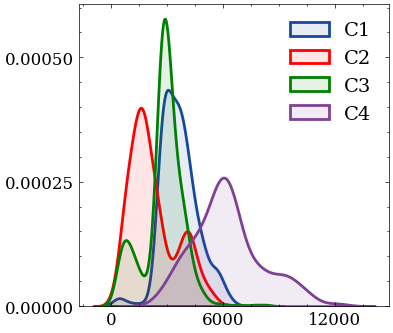

In [30]:
fig=plt.figure(figsize=(4,4),dpi=100)
fs=14
plt.subplot(111)
c_pal=sns.color_palette(['#7D4195','green','red','#16499D'])
ax=sns.kdeplot(data=gfdf,fill=True,
                x='bif_EucDist2soma_max',hue='cluster',
                hue_order=np.arange(n_clusters),
                palette=c_pal,alpha=0.1,
                linewidth=2,
                common_norm=False)
ax.tick_params(axis='x',labelsize=fs-2)
ax.xaxis.set_major_locator(MaxNLocator(3))
ax.tick_params(axis='y',labelsize=fs-2)
ax.yaxis.set_major_locator(MaxNLocator(3))
# ax.yaxis.set_minor_locator(MaxNLocator(3))
# ax.set_yscale('linear')
# plt.legend(labels)
plt.legend(labels=['C'+str(c+1) for c in np.arange(n_clusters)],title='',fontsize=fs)
plt.xlabel('',fontsize=fs)
plt.ylabel('')
plt.show()
fig.savefig('../figs/bif_EucDist2soma_max_of_clusters.png',dpi=300)

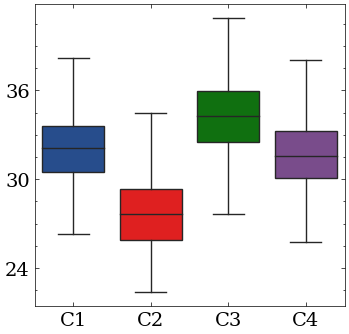

In [31]:
fig=plt.figure(figsize=(4,4),dpi=100)
plt.subplot(111)
ax=sns.boxplot(data=allfeas_df,y='tilt_remote_std',x='cluster',
            palette=sns.color_palette(['#16499D','red','green','#7D4195']),
            showfliers=False
            )

# plt.ylabel('tilt remote std',fontsize=14)
plt.xlabel('')
plt.xticks(ticks=np.arange(n_clusters),labels=['C'+str(c+1) for c in np.arange(n_clusters)],fontsize=14)
ax.tick_params(axis='y',labelsize=14)
ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_minor_locator(MaxNLocator(4))
# plt.yticks(fontsize=12)
plt.ylabel('')
plt.show()
fig.savefig('../figs/tilt_remote_std.png',dpi=300)

### Fig4F

In [32]:
def brlen_density_dist2soma(file_in,d2s_bin_len=400,max_d2s_bins=40,
                        d2sfea='path_dist2soma',lenfea='pathlength'):
    maxdist=100000
    brfea=pd.read_csv(file_in)
    maxd2soma=brfea[d2sfea].max()
    sample_list=[]
    if maxd2soma:
        for bx in np.arange(1,max_d2s_bins+1):
            minbx=d2s_bin_len*(bx-1)
            maxbx=d2s_bin_len*bx
            if bx ==( max_d2s_bins +1):
                maxbx= maxdist
            sdf=brfea[(brfea[d2sfea]>minbx) & (brfea[d2sfea]<=maxbx)].copy()
            # print(sample_list)
            if sdf.shape[0]:
                sample_list.append(sdf[lenfea].shape[0])
            else:
                sample_list.append(0)
    return sample_list

brfea_dir='../data/Fig4/brfeas'
d2s_bin_len=300
max_d2s_bins=40
d2sfea='dist2soma'
# d2sfea='path_dist2soma'
# df_brlen_mean=pd.DataFrame()
# df_brlen_std=pd.DataFrame()
df_br_density=pd.DataFrame()
# df_br_den_std=pd.DataFrame()
for root,dirs,files in os.walk(brfea_dir):
    for mfile in files:
        # print(mfile)
        if os.path.splitext(mfile)[1] != '.csv':
            continue
        file_in=os.path.join(root,mfile)
        # tdata_mean=brlen_mean_dist2soma(file_in=file_in,d2s_bin_len=d2s_bin_len,
        #                             max_d2s_bins=max_d2s_bins,d2sfea=d2sfea)
        # df_brlen_mean[mfile.split('.swc')[0]]=tdata_mean
        # tdata_std=brlen_std_dist2soma(file_in=file_in,d2s_bin_len=d2s_bin_len,
        #                             max_d2s_bins=max_d2s_bins,d2sfea=d2sfea)
        # df_brlen_std[mfile.split('.swc')[0]]=tdata_std
        tdata_density=brlen_density_dist2soma(file_in=file_in,d2s_bin_len=d2s_bin_len,
                                    max_d2s_bins=max_d2s_bins,d2sfea=d2sfea)
        df_br_density[mfile.split('.swc')[0]]=tdata_density

df_br_density=df_br_density.T
df_br_density.index.name='name'

if True:
    for swc in df_br_density.index:
        ctype='error'
        if swc in gfdf.index.to_list():
            ctype=gfdf.loc[swc,'cluster']
        # df_brlen_mean.loc[swc,'cluster']=ctype
        df_br_density.loc[swc,'cluster']=ctype
        # df_brlen_std.loc[swc,'cluster']=ctype
    # df_brlen_mean_feas=df_brlen_mean[(df_brlen_mean.cluster != 'error')].copy()
    df_br_density_feas=df_br_density[(df_br_density.cluster != 'error')].copy()
    # df_brlen_std_feas=df_brlen_std[(df_brlen_std.cluster != 'error')].copy()

df_br_density_stypes=pd.DataFrame()
for stype in np.arange(n_clusters):
    stdf=df_br_density_feas[df_br_density_feas.cluster == stype].copy()
    stdf.drop(['cluster'],axis=1,inplace=True)
    df_br_density_stypes[stype]=stdf.mean()
df_br_density_stypes=df_br_density_stypes.T
df_br_density_stypes.index.name='cluster'

df_br_den_std_stypes=pd.DataFrame()
for stype in np.arange(n_clusters):
    stdf=df_br_density_feas[df_br_density_feas.cluster == stype].copy()
    stdf.drop(['cluster'],axis=1,inplace=True)
    df_br_den_std_stypes[stype]=stdf.std()
df_br_den_std_stypes=df_br_den_std_stypes.T
df_br_den_std_stypes.index.name='cluster'

/Users/jiangshengdian/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:44: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



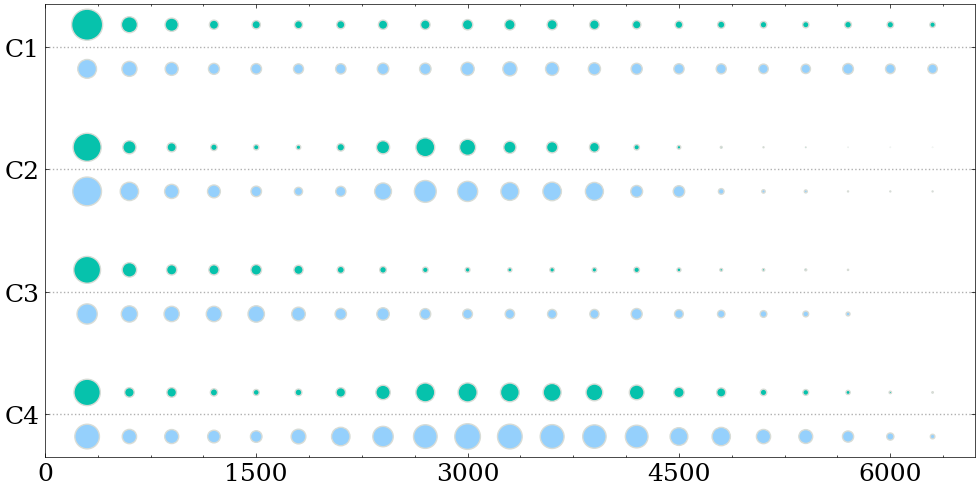

In [33]:
fig=plt.figure(figsize=(12,6),dpi=100)
ax=plt.subplot(111)
all_ana_types=np.arange(n_clusters)
all_ana_types=list(reversed(all_ana_types))

# for br more than 2
for di in np.arange(max_d2s_bins):
    if df_br_density_stypes[max_d2s_bins-di-1].sum() >=5:
        break
xd=np.arange(max_d2s_bins-di-1)
ax_xd=[d2s_bin_len*(int(x)+1) for x in xd]
al=1
yd_h=0.18
yd=[1 for x in xd]
m_max_size=500
mticker.Locator.MAXTICKS = 1000
# blen_max=df_br_tilt_remote_std_stypes.loc[all_ana_types,:].max().max()
# blen_max_type=df_brlen_mean_stypes.loc[all_ana_types,:].max(axis=1).sort_values(ascending=False).index.to_list()[0]
br_num_max=df_br_density_stypes.loc[all_ana_types,:].max(axis=1).sort_values(ascending=False).values[0]
# print(br_num_max,blen_max)
# axlegend=None
# colorlegend=None
for ai,astype in enumerate(all_ana_types):
    # yraw_stype_std=[df_br_tilt_remote_std_stypes.loc[astype,x] for x in xd]
    yraw_stype_brden_std=[df_br_den_std_stypes.loc[astype,x] for x in xd]
    yraw_stype_brden=[df_br_density_stypes.loc[astype,x] for x in xd]
    # for bri,brden_stype in enumerate(yraw_stype_brden):
    #     if brden_stype < 2:
    #         yraw_stype_std[bri]=0
    # ydstype_mean=[m_max_size*df_br_tilt_remote_std_stypes.loc[astype,x]/blen_max for x in xd]
    # ydstype_den=[m_max_size*df_br_density_stypes.loc[astype,x]/br_num_max for x in xd]
    # ydstype_mean=[m_max_size*yraw_stype_std[x]/blen_max for x in xd]
    ydstype_den=[m_max_size*yraw_stype_brden[x]/br_num_max for x in xd]
    ydstype_den_std=[m_max_size*yraw_stype_brden_std[x]/br_num_max for x in xd]
    # yd_colors=[df_br_density_stypes.loc[astype,x] for x in xd]
    # ax.scatter(x=ax_xd,y=[y+ai+yd_h for y in yd],s=ydstype_mean,c='#95d0fc',alpha=al,marker='o',edgecolors='#d8dcd6')
    ax.scatter(x=ax_xd,y=[y+ai+yd_h for y in yd],s=ydstype_den,c='#06c2ac',alpha=al,marker='o',edgecolors='#d8dcd6')
    ax.scatter(x=ax_xd,y=[y+ai-yd_h for y in yd],s=ydstype_den_std,c='#95d0fc',alpha=al,marker='o',edgecolors='#d8dcd6')
# plt.colorbar()
ax.tick_params(axis='x',labelsize=18)
ax.tick_params(axis='y',labelsize=18)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_minor_locator(MaxNLocator(1))
ax.set_yticks(np.arange(1,1+len(all_ana_types)))
ax.set_yticklabels(['C'+str(n_clusters-c) for c in np.arange(n_clusters)])
plt.grid(axis='y',linestyle=':',linewidth=1)
plt.show()
fig.savefig('../figs/cluster_br_'+str(int(br_num_max))+'_at_'+d2sfea+'.png',dpi=300)